# Lab02 - SLURM part 1

### Imports

In [1]:
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten

import numpy as np
import cupy as cp
import time

import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from datetime import datetime

2025-03-16 13:57:49.409878: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 13:57:49.425151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742129869.442829 2317250 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742129869.448275 2317250 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742129869.462244 2317250 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Task 0 Run code

In [2]:
# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

# Define the model
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

[]


W0000 00:00:1742129873.430927 2317250 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/net/afscra/people/plgadrianmadej/.conda/envs/matrix_env_lab02/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8777 - loss: 0.4360
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9633 - loss: 0.1228
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9756 - loss: 0.0806
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9814 - loss: 0.0606
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9862 - loss: 0.0460
313/313 - 0s - 1ms/step - accuracy: 0.9754 - loss: 0.0801

Test accuracy: 0.9753999710083008


### Task 1 Compare matrix multipliaction

In [3]:
# Function to perform matrix multiplication and return time
def matrix_multiply_and_time(matrix_size, device):
    
    if device == 'cpu':
        # Create random matrices
        A = np.random.rand(matrix_size, matrix_size)
        B = np.random.rand(matrix_size, matrix_size)
        
        # CPU matrix multiplication
        start_time = time.time()
        C = np.dot(A, B)
        return time.time() - start_time

    elif device == 'gpu':
         # Create random matrices
        A = cp.random.rand(matrix_size, matrix_size, dtype=cp.float32)
        B = cp.random.rand(matrix_size, matrix_size, dtype=cp.float32)
        
        # GPU matrix multiplication
        start_time = time.time()
        C = cp.dot(A, B)
        return time.time() - start_time

# Sizes to test
sizes = [2_000, 4_000, 6_000, 8_000, 10_000, 12_000, 14_000]

# Run tests and collect times
results = {'size': [], 'cpu_avg_time': [], 'gpu_avg_time': []}

for size in sizes:
    cpu_times = []
    gpu_times = []
    
    for _ in range(5):  # Repeat 5 times for each matrix size
        # Run CPU test
        cpu_time = matrix_multiply_and_time(size, 'cpu')
        cpu_times.append(cpu_time)
        
        # Run GPU test
        gpu_time = matrix_multiply_and_time(size, 'gpu')
        gpu_times.append(gpu_time)
    
    # Calculate average times
    avg_cpu_time = np.mean(cpu_times)
    avg_gpu_time = np.mean(gpu_times)
    
    # Store results
    results['size'].append(size)
    results['cpu_avg_time'].append(avg_cpu_time)
    results['gpu_avg_time'].append(avg_gpu_time)
    
    print(f"Results for N={size}:")
    print(f"  Average CPU time: {avg_cpu_time:.2f} seconds")
    print(f"  Average GPU time: {avg_gpu_time:.2f} seconds\n")


df = pd.DataFrame(results)
df

Results for N=2000:
  Average CPU time: 0.23 seconds
  Average GPU time: 0.00 seconds

Results for N=4000:
  Average CPU time: 1.76 seconds
  Average GPU time: 0.00 seconds

Results for N=6000:
  Average CPU time: 5.80 seconds
  Average GPU time: 0.00 seconds

Results for N=8000:
  Average CPU time: 13.65 seconds
  Average GPU time: 0.00 seconds

Results for N=10000:
  Average CPU time: 26.52 seconds
  Average GPU time: 0.00 seconds

Results for N=12000:
  Average CPU time: 45.61 seconds
  Average GPU time: 0.00 seconds

Results for N=14000:
  Average CPU time: 71.99 seconds
  Average GPU time: 0.00 seconds



,size,cpu_avg_time,gpu_avg_time
0,2000,0.233141,0.003539
1,4000,1.757703,0.000134
2,6000,5.804696,0.000127
3,8000,13.650398,0.000407
4,10000,26.518434,0.000121
5,12000,45.613499,0.000137
6,14000,71.991412,0.000136


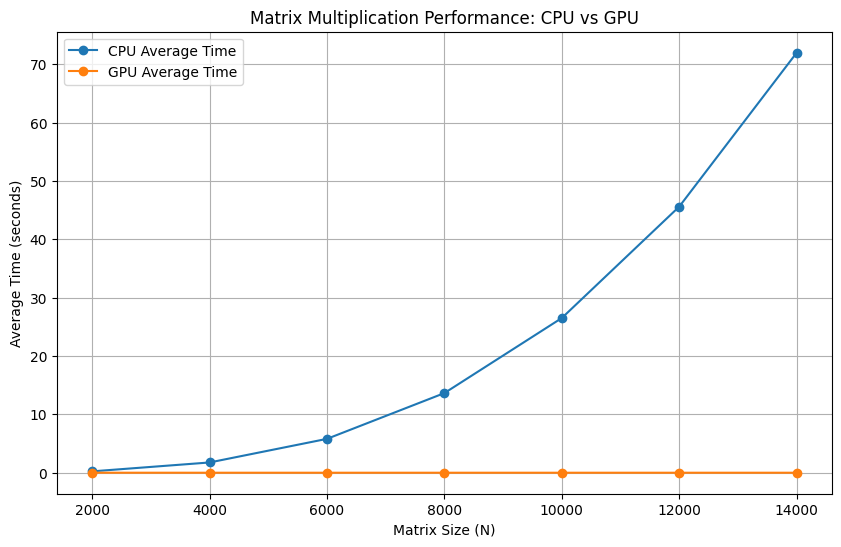

In [4]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df['size'], df['cpu_avg_time'], label='CPU Average Time', marker='o')
plt.plot(df['size'], df['gpu_avg_time'], label='GPU Average Time', marker='o')
plt.xlabel('Matrix Size (N)')
plt.ylabel('Average Time (seconds)')
plt.title('Matrix Multiplication Performance: CPU vs GPU')
plt.legend()
plt.grid(True)
plt.show()

#### Interpretation

As the matrix size increases, the CPU time grows significantly due to its lack of parallel processing, demonstrating quadratic time complexity. In contrast, the GPU time remains almost constant, showcasing its ability to efficiently handle large matrix multiplications with minimal computational cost. The GPU is orders of magnitude faster than the CPU, especially for larger matrices, with the difference growing as the size increases. This performance gap highlights the scalability advantage of GPUs for large-scale computations. Overall, the GPU is far superior for tasks like matrix multiplication, making it the preferred choice for handling large matrices efficiently.

Link to conversation with the chat: https://chatgpt.com/share/67d5d6cf-7f8c-800c-b637-4217e5b5c459

### Task 2.0 Data analysis

In [5]:
data_path = os.path.expandvars("$PLG_GROUPS_STORAGE/plgglscclass/yelp-dataset/yelp_academic_dataset_tip.json")
df = pd.read_json(data_path, lines=True)

df.head()

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0


##### Information about data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908915 entries, 0 to 908914
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           908915 non-null  object        
 1   business_id       908915 non-null  object        
 2   text              908915 non-null  object        
 3   date              908915 non-null  datetime64[ns]
 4   compliment_count  908915 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 34.7+ MB


##### Descriptive statistics for numerical columns

In [7]:
df.describe()

,date,compliment_count
count,908915,908915.000000
mean,2015-06-14 10:13:53.302817280,0.012525
min,2009-04-16 13:11:49,0.000000
25%,2013-01-26 01:18:02.500000,0.000000
50%,2015-03-15 01:10:25,0.000000
75%,2017-08-02 06:19:55.500000,0.000000
max,2022-01-19 20:38:55,6.000000
std,NaN,0.120763


##### Missing Data Summary

In [8]:
df.isnull().sum()

user_id             0
business_id         0
text                0
date                0
compliment_count    0
dtype: int64

##### Text length

In [9]:
df['text_length'] = df['text'].apply(len)

df[['text', 'text_length']].head()

,text,text_length
0,Avengers time with the ladies.,30
1,They have lots of good deserts and tasty cuban...,57
2,It's open even when you think it isn't,38
3,Very decent fried chicken,25
4,Appetizers.. platter special for lunch,38


##### Date Analysis

In [10]:
df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday

df[['date', 'year', 'month', 'day', 'weekday']].head()

,date,year,month,day,weekday
0,2012-05-18 02:17:21,2012,5,18,4
1,2013-02-05 18:35:10,2013,2,5,1
2,2013-08-18 00:56:08,2013,8,18,6
3,2017-06-27 23:05:38,2017,6,27,1
4,2012-10-06 19:43:09,2012,10,6,5


##### Review per month

In [11]:
reviews_per_month = df.groupby(['year', 'month']).size()

reviews_per_month

year  month
2009  4          47
      5          64
      6          72
      7          75
      8          92
               ... 
2021  9        2708
      10       2868
      11       2785
      12       1777
2022  1         925
Length: 154, dtype: int64

##### Reviews in 2009

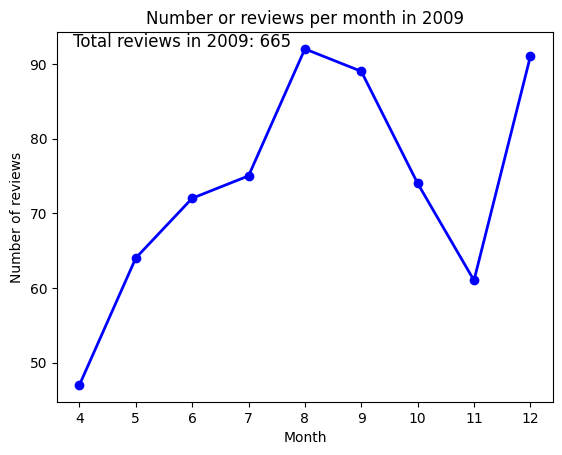

In [12]:
df_2009 = df[df['year'] == 2009]

reviews_per_month_2009 = df_2009.groupby(['month']).size()

total_reviews_2009 = reviews_per_month_2009.sum()

reviews_per_month_2009.plot(kind='line', marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

plt.title('Number or reviews per month in 2009')
plt.xlabel('Month')
plt.ylabel('Number of reviews')

plt.figtext(0.15, 0.85, f'Total reviews in 2009: {total_reviews_2009}', fontsize=12, ha='left')

plt.show()

##### Reviews per year

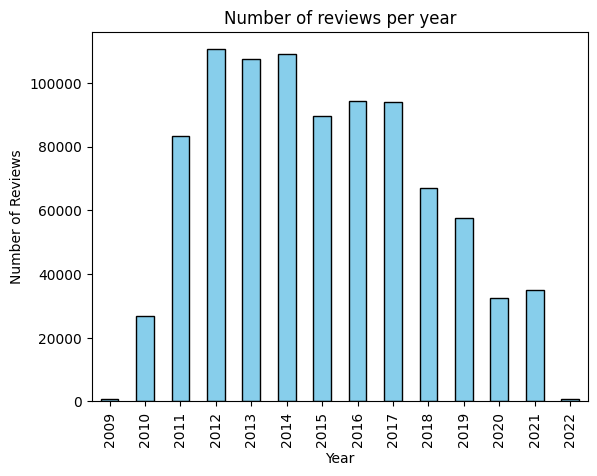

In [13]:
reviews_per_year = df.groupby(['year']).size()

reviews_per_year.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of reviews per year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')

plt.show()

##### Users with compliments

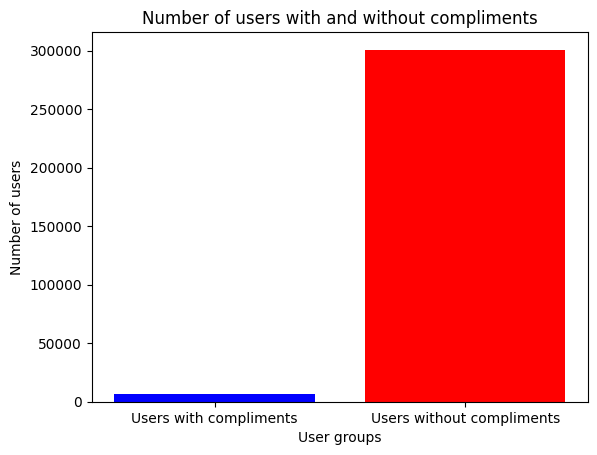

Total number of unique users: 307304
Number of unique users who gave compliments: 6462
Number of unique users who did not give compliments: 300842


In [14]:
users_with_compliments = df[df['compliment_count'] > 0]['user_id'].nunique()

users_without_compliments = df[df['compliment_count'] == 0]['user_id'].nunique()

labels = ['Users with compliments', 'Users without compliments']
values = [users_with_compliments, users_without_compliments]

plt.bar(labels, values, color=['blue', 'red'])

plt.title('Number of users with and without compliments')
plt.xlabel('User groups')
plt.ylabel('Number of users')

plt.show()

total_users = users_with_compliments + users_without_compliments

print(f"Total number of unique users: {total_users}")
print(f"Number of unique users who gave compliments: {users_with_compliments}")
print(f"Number of unique users who did not give compliments: {users_without_compliments}")

##### Users with most compliments

In [15]:
top_users_compliments = df.groupby('user_id')['compliment_count'].sum().sort_values(ascending=False).head(5)

print("Top 5 users with the most compliments:")
top_users_compliments

Top 5 users with the most compliments:


user_id
fCvMnJU1Z-XhAjKg99wK3Q    190
sraTrYU-7q_bQ0TxQrLJvQ     82
A4bsa7ykYRVCnb4h2vZALw     75
tsMF0FcFcHZ8i28WzWtQXw     66
DwaaafwryFbW7C4E1gU1AA     62
Name: compliment_count, dtype: int64

### Commands used to configure environments:

```bash
srun --time=2:00:00 --mem=8G --ntasks 1 --gres=gpu:1 --partition=plgrid-gpu-v100 --account=plglscclass24-gpu --pty /bin/bash

conda info --envs
conda config --add envs_dirs ${SCRATCH}/.conda/envs
conda config --add pkgs_dirs ${SCRATCH}/.conda/pkgs
conda create --prefix $SCRATCH/.conda/envs/matrix_env_lab02 python=3.9 -y

conda activate ${SCRATCH}/.conda/envs/matrix_env_lab02

module load cuda
pip install cupy-cuda12x
pip install jupyter
pip install tensorflow
pip install pandas
pip install matplotlib

jupyter notebook --no-browser --port=<port> --ip=<node_name>
```